In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

path = input('Por favor adicione o diretorio de trabalho?')
for dirname, _, filename in os.walk(path, topdown = True):
    for filename in filename:
        if filename == 'test.csv':
                teste = pd.read_csv(os.path.join(dirname,filename))
        else:
            if filename == 'train.csv':
                treino = pd.read_csv(os.path.join(dirname,filename))
            else:
                print("Deu ruim irmão!!")

X = treino.drop(['Cover_Type','Id','Unnamed: 0'],axis=1) 
y= treino.Cover_Type
test_ids = teste['Id']

#Coleta de Dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

Dtrain = xgb.DMatrix(X_train, label=y_train)
Dtest = xgb.DMatrix(X_test, label=y_test)
teste.drop(['Id','Unnamed: 0'],axis=1,inplace = True)
Dpred = xgb.DMatrix(teste)

Por favor adicione o diretorio de trabalho? C:\github\Kaggle_Challenges\Machine_Learning_Competitions\data


C:\Users\PC\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


# GridSearch - Encontrando os melhores parametros

In [89]:
# GridSearch

num_boost_round = [100, 150] 
max_depth = [20,30]  
learning_rate = [0.1,0.2,0.3]

param_grid = {'num_boost_round': num_boost_round,
              'max_depth': max_depth,
               'learning_rate':learning_rate}

est = xgb.XGBClassifier(max_depth = 10,num_boost_round=100 )

grid = GridSearchCV(est,param_grid, n_jobs=-1, cv=3, verbose = 1, refit = True, scoring = 'neg_log_loss')
gridcv = grid.fit(X_train,y_train)
gridcv.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 16.3min finished


{'learning_rate': 0.1, 'max_depth': 20, 'num_boost_round': 100}

# Treinando o modelo

[0]	eval-merror:0.198413	train-merror:0.08755
[0]	eval-merror:0.198413	train-merror:0.08755
[1]	eval-merror:0.182209	train-merror:0.066799
[2]	eval-merror:0.169643	train-merror:0.053323
[3]	eval-merror:0.166005	train-merror:0.045552
[4]	eval-merror:0.168981	train-merror:0.041501
[5]	eval-merror:0.166336	train-merror:0.03497
[6]	eval-merror:0.167328	train-merror:0.031994
[7]	eval-merror:0.164683	train-merror:0.030093
[8]	eval-merror:0.162698	train-merror:0.027943
[9]	eval-merror:0.159392	train-merror:0.02505
[10]	eval-merror:0.15873	train-merror:0.022735
[11]	eval-merror:0.156746	train-merror:0.02042
[12]	eval-merror:0.156085	train-merror:0.017526
[13]	eval-merror:0.155093	train-merror:0.016369
[14]	eval-merror:0.154431	train-merror:0.013889
[15]	eval-merror:0.150794	train-merror:0.012649
[16]	eval-merror:0.152116	train-merror:0.01083
[17]	eval-merror:0.148479	train-merror:0.009755
[18]	eval-merror:0.146164	train-merror:0.009177
[19]	eval-merror:0.14418	train-merror:0.00835
[20]	eval-me

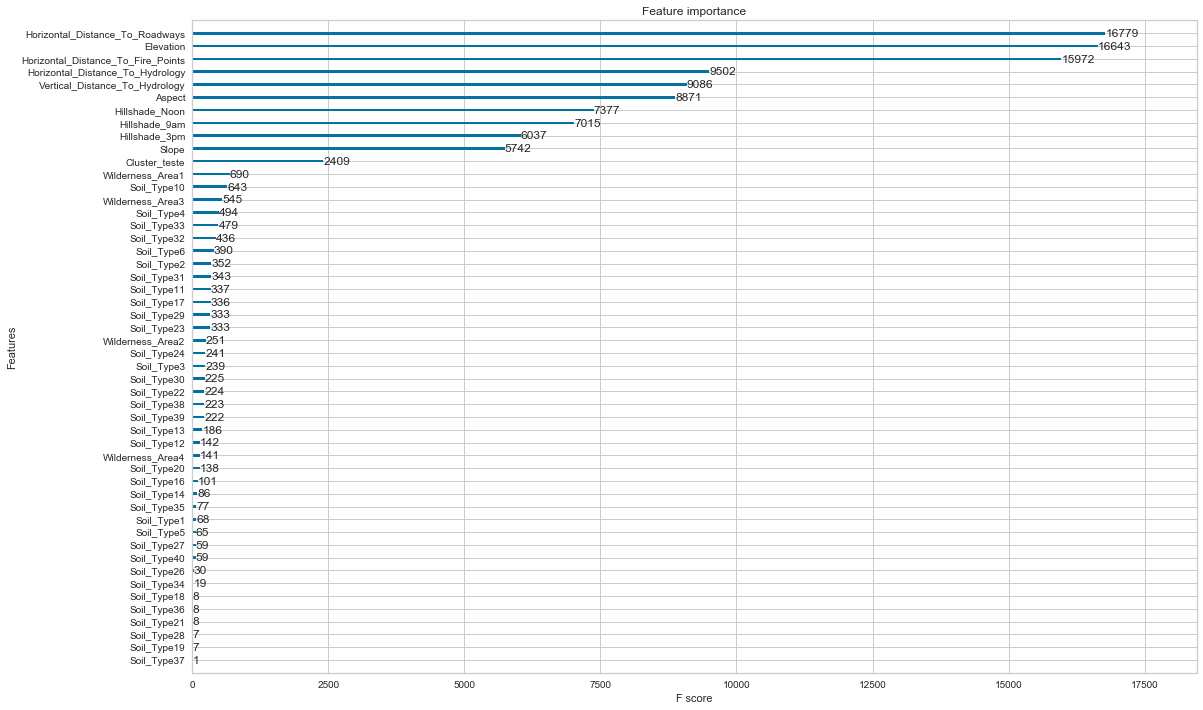

Wall time: 55.6 s


In [18]:
%%time
#XGBoost

#Treinamento
num_class = 8
objective = "multi:softmax"
predictor = 'cpu_predictor'
booster = 'gbtree'
grow_policy = 'depthwise'
max_depth = 20
gamma = 0
num_parallel_tree = 1
num_boost_round = 100
learning_rate = 0.1
colsample_bynode= 1
subsample=1
min_child_weight=1
reg_lambda = 1
alpha = 0
max_leaves = 0
process_type = 'update'
eval_metric = {'eval_metric': 'merror'}
watchlist = [(Dtest, 'eval'), (Dtrain, 'train')]


params= {'max_depth' : max_depth,
         'gamma': gamma,
         'objective': objective,
         'num_class' : num_class,
         'num_parallel_tree' : num_parallel_tree, 
         'num_boost_round' : num_boost_round,
         'learning_rate': learning_rate,
         'colsample_bynode': colsample_bynode,
         'subsample': subsample,
         'min_child_weight':min_child_weight,
         'reg_lambda':reg_lambda,
         'alpha':alpha,
         'max_leaves':max_leaves,
         'predictor' : predictor,
         'booster' : booster,
         'grow_policy' :grow_policy}


bst= xgb.train( dtrain = Dtrain, params=params, num_boost_round=num_boost_round, 
                                   evals=watchlist, 
                                   obj=None,
                                   feval=None,
                                   xgb_model=None,
                                   maximize=False,
                                   #early_stopping_rounds= 3, 
                                   verbose_eval=100,
                                   callbacks=[xgb.callback.print_evaluation(show_stdv=True)])


#Salvando o modelo
print('\n')
print('>Salvando o modelo...')
bst.save_model('xg_model.model')

#Pred para classfication report
predM = xgb.DMatrix(X_test)
pred= bst.predict(predM)

print('\n')
print(classification_report(y_test,pred))
print('\n')
acc = 1-(np.sum(pred != y_test) / y_test.shape[0])
print('Acuracia de teste = {}'.format(acc))

print('\n')
print('>Gerando o Submission File...')

#Submission
p_sub = bst.predict(Dpred)
sub = pd.DataFrame(p_sub, index = test_ids, columns=['Cover_Type'])
sub.to_csv('xgb_sub.csv')
print(sub.shape)
print('Arquivo salvo!')

f, ax = plt.subplots(figsize=(18,12)) 
xgb.plot_importance(bst, ax=ax)
plt.show()